Next, we want to see whether scLEMBAS can capture the heterogeneity of cell responses upon ligand exposure. 

In [1]:
import os

import numpy as np
import pandas as pd

import scanpy as sc
from sklearn.neighbors import NearestCentroid
from scipy.spatial.distance import cdist, pdist, squareform

import torch

import matplotlib.pyplot as plt

import sys
# lembas_path = '/nobackup/users/hmbaghda/Software/LEMBAS'
lembas_path = '/nobackup/users/hmbaghda/Software/avlant_LEMBASGPU'

sclembas_path = '/home/hmbaghda/Projects/scLEMBAS/scLEMBAS'
sys.path.insert(1, os.path.join(sclembas_path))
from model.bionetwork import format_network, SignalingModel

/tmp/ipykernel_1628383/1969642366.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
n_cores = 12
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

seed = 888
data_path = '/nobackup/users/hmbaghda/scLEMBAS/analysis'

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
tf_adata = sc.read_h5ad(os.path.join(data_path, 'processed', 'ID_tf_activity.h5ad'))

The simplest scenario is no ligand and exposure to one ligand at uniform concentration, leading to distinct clusters in TF activity space (the prediction output). Thus, let's start with this. To identify the two most distinct clusters, let's calculate the Euclidean distance of the cluster centroids in PC space:

In [34]:
group_label = 'TF_clusters' # ordered cateogry in obs

pca_rank = tf_adata.uns['pca']['pca_rank']
X_pca = tf_adata.obsm['X_pca'][:, :pca_rank] # PCA to pca_rank components

clf = NearestCentroid()
clf.fit(X_pca, np.array(tf_adata.obs[group_label]))
centroids = clf.centroids_ # group labels x n_pcs
ped = squareform(pdist(centroids, 'euclidean')) # euclidean distance between all centroids

max_clusters = np.unravel_index(np.argmax(ped), ped.shape)
max_clusters = [clf.classes_[i] for i in max_clusters]
print('Centroid euclidean distance in PC space is maximized between cluster {} and {} ({} PCs)'.format(*max_clusters, tf_adata.uns['pca']['pca_rank']))

ped_ = ped.copy()
np.fill_diagonal(ped_, np.inf)
min_clusters = np.unravel_index(np.argmin(ped_), ped_.shape)
min_clusters = [clf.classes_[i] for i in min_clusters]
print('Centroid euclidean distance in PC space is minimized between cluster {} and {} ({} PCs)'.format(*min_clusters, tf_adata.uns['pca']['pca_rank']))

Centroid euclidean distance in PC space is maximized between cluster 11 and 15 (8 PCs)
Centroid euclidean distance in PC space is minimized between cluster 11 and 9 (8 PCs)


Let's also get the within-cluster dispersion, as measured by WCSS. We adapt the below equation of WCSS to calculate just the inner sum for each cluster(not summing across all clusters, which gives one metric of overall dispersion) and normalize to the total number of points in the cluster:



$$
\text{WCSS} = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} [d(\mathbf{x}, \mathbf{\mu}_i)]^2
$$


- $k$: The number of clusters.
- $C_i$: The set of points belonging to the $i$-th cluster.
- $\mathbf{x}$: A data point within a cluster $C_i$.
- $\mathbf{\mu}_i$: The centroid of the $i$-th cluster, which is the average position of all the points in $C_i$.
- $d(\mathbf{x}, \mathbf{\mu}_i)$: The distance between a data point $\mathbf{x}$ and the centroid (here calculated as Euclidean distance)

Our WCSS:

For each $k$k:
$$
\text{WCSS} = \sum_{\mathbf{x} \in C_i} [d(\mathbf{x}, \mathbf{\mu}_i)]^2 / n
$$

- $n$: The total number of points in the cluster


In [130]:
WCSS = {}
for i, centroid in enumerate(centroids):
    cluster_label = clf.classes_[i]
    cluster_indeces = cluster_map[cluster_map.TF_clusters == cluster_label].index.tolist()
    cluster_points = X_pca[cluster_indeces,:]

    # squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
    euclidean_distance = cdist(cluster_points, [centroid], 'euclidean')
    squared_distances = np.sum(euclidean_distance**2, axis = 1)

    WCSS[cluster_label] = np.sum(euclidean_distance**2)/cluster_points.shape[0]

WCSS = pd.DataFrame(WCSS.items(), columns = ['TF_cluster', 'WCSS'])
max_cluster, min_cluster = WCSS.loc[WCSS.WCSS.idxmax(), 'TF_cluster'], WCSS.loc[WCSS.WCSS.idxmin(),  'TF_cluster']
print('Cluster {} has the max dispersion in PC space'.format(max_cluster))
print('Cluster {} has the min dispersion in PC space'.format(min_cluster))

Cluster 8 has the max dispersion in PC space
Cluster 11 has the min dispersion in PC space


/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired v

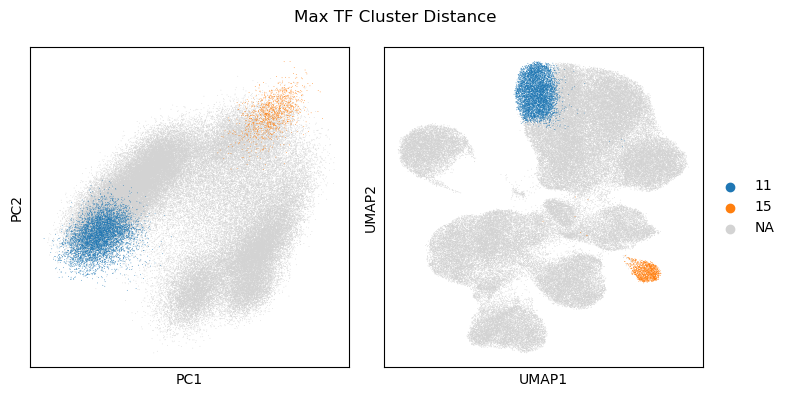

In [37]:
viz_adata = tf_adata.copy()
viz_adata.obs[group_label + '_color'] = pd.Categorical(viz_adata.obs[group_label], 
                                                       categories = max_clusters, 
                                                       ordered = True)
fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))
sc.pl.pca(viz_adata, color=group_label + '_color', ax = ax[0], show = False)
ax[0].legend().set_visible(False)
ax[0].set_title('')
sc.pl.umap(viz_adata, color=group_label + '_color', ax = ax[1], show = False)
ax[1].set_title('')

fig.suptitle('Max TF Cluster Distance')

fig.tight_layout()
# plt.savefig(fname = os.path.join(data_path, 'figures', 'tf_celltype_umap.png'), 
#             transparent = True, 
#             bbox_inches = 'tight')
plt.show()

Thus, we will proceed with the TF clusters 11 and 15, stating that cluster 11 corresponds to a control (no ligand) and cluster 15 corresponds to an input ligand (at uniform concentration). 

/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired v

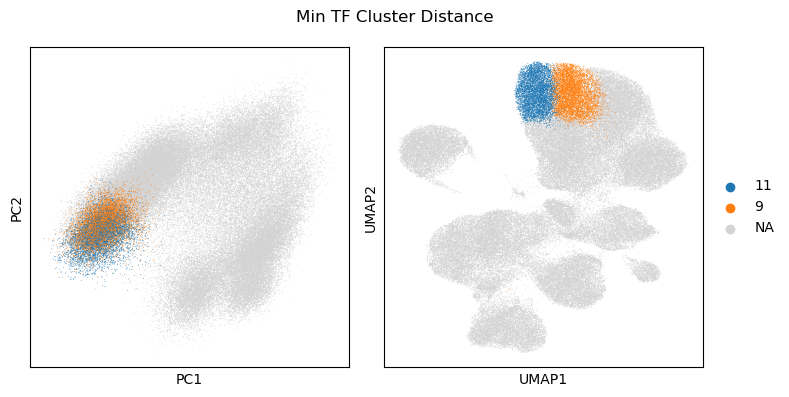

In [38]:
viz_adata = tf_adata.copy()
viz_adata.obs[group_label + '_color'] = pd.Categorical(viz_adata.obs[group_label], 
                                                       categories = min_clusters, 
                                                       ordered = True)
fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))
sc.pl.pca(viz_adata, color=group_label + '_color', ax = ax[0], show = False)
ax[0].legend().set_visible(False)
ax[0].set_title('')
sc.pl.umap(viz_adata, color=group_label + '_color', ax = ax[1], show = False)
ax[1].set_title('')

fig.suptitle('Min TF Cluster Distance')

fig.tight_layout()
# plt.savefig(fname = os.path.join(data_path, 'figures', 'tf_celltype_umap.png'), 
#             transparent = True, 
#             bbox_inches = 'tight')
plt.show()

/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired v

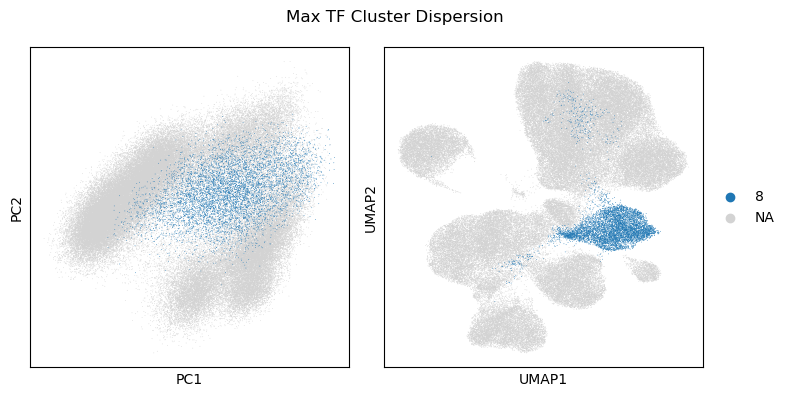

In [133]:
viz_adata = tf_adata.copy()
viz_adata.obs[group_label + '_color'] = pd.Categorical(viz_adata.obs[group_label], 
                                                       categories = [max_cluster], 
                                                       ordered = True)
fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))
sc.pl.pca(viz_adata, color=group_label + '_color', ax = ax[0], show = False)
ax[0].legend().set_visible(False)
ax[0].set_title('')
sc.pl.umap(viz_adata, color=group_label + '_color', ax = ax[1], show = False)
ax[1].set_title('')

fig.suptitle('Max TF Cluster Dispersion')

fig.tight_layout()
# plt.savefig(fname = os.path.join(data_path, 'figures', 'tf_celltype_umap.png'), 
#             transparent = True, 
#             bbox_inches = 'tight')
plt.show()

/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired v

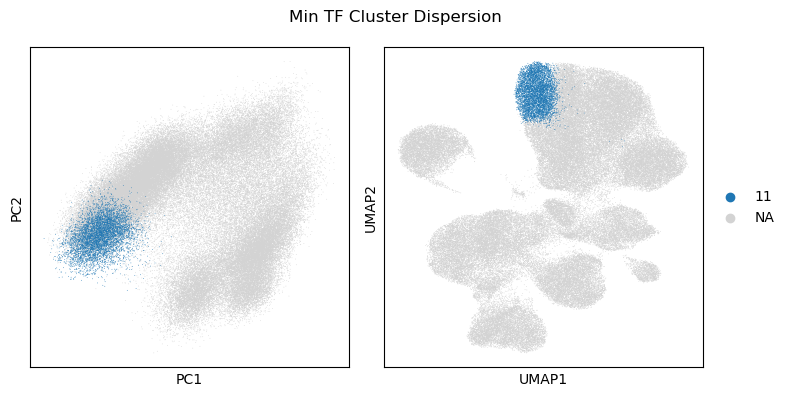

In [135]:
viz_adata = tf_adata.copy()
viz_adata.obs[group_label + '_color'] = pd.Categorical(viz_adata.obs[group_label], 
                                                       categories = [min_cluster], 
                                                       ordered = True)
fig, ax = plt.subplots(ncols = 2, figsize = (8, 4))
sc.pl.pca(viz_adata, color=group_label + '_color', ax = ax[0], show = False)
ax[0].legend().set_visible(False)
ax[0].set_title('')
sc.pl.umap(viz_adata, color=group_label + '_color', ax = ax[1], show = False)
ax[1].set_title('')

fig.suptitle('Min TF Cluster Dispersion')

fig.tight_layout()
# plt.savefig(fname = os.path.join(data_path, 'figures', 'tf_celltype_umap.png'), 
#             transparent = True, 
#             bbox_inches = 'tight')
plt.show()

# Model here

Load Data:

In [8]:
# prior knowledge signaling network
net = pd.read_csv(os.path.join(lembas_path, 'data', 'macrophage-Model.tsv'), sep = '\t', index_col = False)

# ligand input and TF output
ligand_input = pd.read_csv(os.path.join(lembas_path, 'data', 'macrophage-Ligands.tsv'), sep='\t', low_memory=False, index_col=0)
tf_output = pd.read_csv(os.path.join(lembas_path, 'data', 'macrophage-TFs.tsv'), sep='\t', low_memory=False, index_col=0)

Let's see what the signaling network looks like:

In [9]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
0,P49137,Q16539,0,0
1,Q16539,P49137,1,0
2,P31749,O15111,1,0
3,O15111,P19838,1,0
4,P19838,O15111,0,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [10]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()

,source,target,mode_of_action,stimulation,inhibition
0,P49137,Q16539,0.1,0,0
1,Q16539,P49137,1.0,1,0
2,P31749,O15111,1.0,1,0
3,O15111,P19838,1.0,1,0
4,P19838,O15111,0.1,0,0


Next, let's initialize the model and format the inputs/outputs for running the model:

In [47]:
training_parameters = {'targetSteps': 100, 'maxSteps': 150, 'expFactor':50, 'tolerance': 1e-5, 'leak':1e-2}
mod = SignalingModel(net = net,
                     X_in = ligand_input,
                     y_out = tf_output, 
                     projection_amplitude = 3, projection_factor = 1.2,
                     weight_label = 'mode_of_action', source_label = 'source', target_label = 'target',
                     bionet_params = training_parameters, dtype = torch.float32, device = device)

X_in = mod.df_to_tensor(mod.X_in)
y_out = mod.df_to_tensor(mod.y_out)

The ligand input, after filtering for nodes in the network, looks like this:

In [68]:
mod.X_in.head()

,Ligand_GC,Ligand_IC,Ligand_IFNb,Ligand_IFNg,Ligand_IL10,Ligand_IL13,Ligand_IL4,Ligand_LPSc,Ligand_P3C,Ligand_PGE2,Ligand_TNFa,Ligand_upLPS
CON,0,0,0,0,0,0,0,0,0,0,0,0
GC,1,0,0,0,0,0,0,0,0,0,0,0
IFNb,0,0,1,0,0,0,0,0,0,0,0,0
IFNb+TNFa+PGE2+P3C,0,0,1,0,0,0,0,0,1,1,1,0
IFNb+TNFa+PGE2+P3C+IFNg,0,0,1,1,0,0,0,0,1,1,1,0


The TF activity output, after filtering for nodes in the network, looks like this:

In [52]:
mod.y_out.head()

,O43524,O75030,P01100,P01106,P03372,P04637,P05412,P08047,P10070,P10242,...,Q07869,Q08050,Q12778,Q13127,Q13485,Q14186,Q16665,Q9H3D4,Q9NQB0,Q9UJU2
CON,0.543487,0.506355,0.288705,0.524944,0.508840,0.535930,0.456016,0.799885,0.465701,0.407298,...,0.479674,0.404891,0.409449,0.568049,0.439274,0.702048,0.450063,0.147630,0.384904,0.677774
GC,0.677927,0.617778,0.119494,0.724938,0.613868,0.796771,0.011826,0.439144,0.421594,0.677585,...,0.299406,0.103314,0.656781,0.440104,0.544396,0.482236,0.094289,0.250332,0.209280,0.637135
IFNb,0.384689,0.621748,0.109474,0.352545,0.558823,0.512618,0.187316,0.326541,0.430194,0.573846,...,0.505945,0.732870,0.513355,0.429696,0.509111,0.545478,0.131642,0.557754,0.465558,0.649616
IFNb+TNFa+PGE2+P3C,0.894344,0.618304,0.815526,0.029120,0.789124,0.627074,0.393195,0.551965,0.399580,0.498236,...,0.241678,0.735164,0.709700,0.383326,0.503909,0.150867,0.736157,0.556562,0.390066,0.232772
IFNb+TNFa+PGE2+P3C+IFNg,0.757642,0.506760,0.772328,0.033346,0.645125,0.762146,0.619820,0.420949,0.406377,0.303368,...,0.088150,0.655950,0.762460,0.409982,0.199154,0.199775,0.818583,0.677592,0.346423,0.165553


In [78]:
self = ProjectInput(mod.node_idx_map, mod.input_labels, projection_amplitude = 3, dtype = mod.dtype)